In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shap

In [2]:
# Load datasets
train_dir = "train_cleaned.csv"
test_dir = "test.csv"

# Read the data
train_data = pd.read_csv(train_dir)
#test_data = pd.read_csv(test_dir)

In [3]:
train_data.head()

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Hospital_code_10,Hospital_code_11,...,City_Code_Patient_35,City_Code_Patient_36,City_Code_Patient_37,City_Code_Patient_38,City_Code_Patient_4,City_Code_Patient_5,City_Code_Patient_6,City_Code_Patient_7,City_Code_Patient_8,City_Code_Patient_9
0,0.125000,0.333333,1.0,1.0,0.0625,0.555556,0.337858,0,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.451129,4,False,False,...,False,False,False,False,False,False,False,True,False,False
2,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.319831,3,True,False,...,False,False,False,False,False,False,False,True,False,False
3,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.594266,4,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.408123,4,False,False,...,False,False,False,False,False,False,False,True,False,False


In [4]:
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
xgb_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y_train)), eval_metric="mlogloss")

In [9]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=11, num_parallel_tree=None, ...)

In [8]:
y_pred = xgb_clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4236
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.15      0.22      4721
           1       0.43      0.49      0.46     15628
           2       0.42      0.67      0.52     17498
           3       0.43      0.22      0.29     11032
           4       0.14      0.00      0.01      2349
           5       0.40      0.50      0.45      7004
           6       0.00      0.00      0.00       549
           7       0.34      0.04      0.07      2051
           8       0.38      0.22      0.28       967
           9       0.37      0.03      0.05       553
          10       0.55      0.42      0.48      1336

    accuracy                           0.42     63688
   macro avg       0.35      0.25      0.26     63688
weighted avg       0.41      0.42      0.39     63688

Confusion Matrix:
 [[  729  2251  1690    35     2    12     0     0     0     0     2]
 [  415  7687  6281   732     7   487     2    11     1   

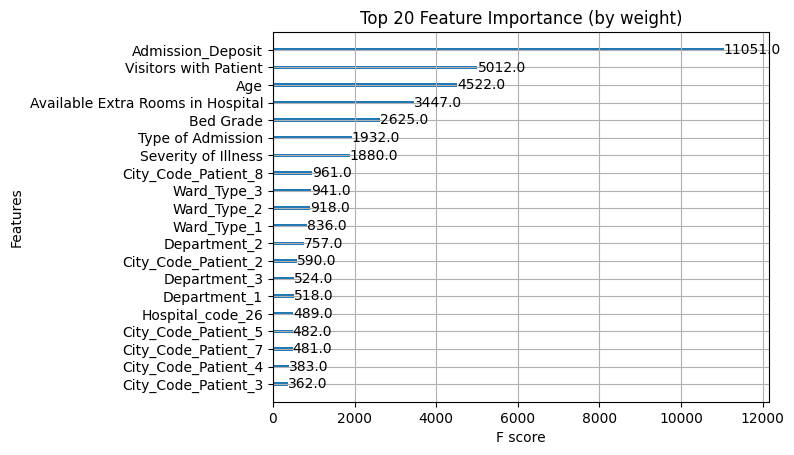

In [9]:
xgb.plot_importance(xgb_clf, importance_type="weight", max_num_features=20)
plt.title("Top 20 Feature Importance (by weight)")
plt.show()

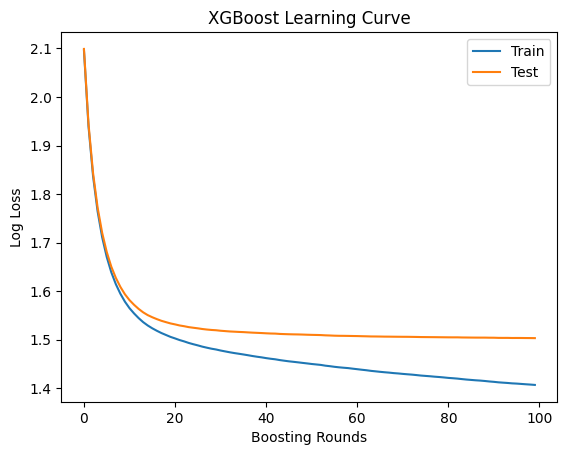

In [10]:
results = xgb_clf.evals_result()

epochs = len(results["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

plt.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
plt.plot(x_axis, results["validation_1"]["mlogloss"], label="Test")

plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.show()

In [11]:
import optuna
from sklearn.model_selection import StratifiedKFold

In [13]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": len(set(y_train)),
        "eval_metric": "mlogloss",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True),
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    acc_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train[train_idx], X_train[valid_idx]
        y_train_fold, y_valid_fold = y_train[train_idx], y_train[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_valid_fold)
        acc_scores.append(accuracy_score(y_valid_fold, y_pred))

    return sum(acc_scores) / len(acc_scores)

In [14]:
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

print("Class distribution in y_train:", train_counts)
print("Class distribution in y_test:", test_counts)

Class distribution in y_train: [18883 62511 69993 44127  9394 28014  2195  8203  3871  2212  5347]
Class distribution in y_test: [ 4721 15628 17498 11032  2349  7004   549  2051   967   553  1336]


In [15]:
print("y_train unique values:", np.unique(y_train))
print("y_test unique values:", np.unique(y_test))

y_train unique values: [ 0  1  2  3  4  5  6  7  8  9 10]
y_test unique values: [ 0  1  2  3  4  5  6  7  8  9 10]


In [16]:
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
X_train = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-04-03 12:09:34,113] A new study created in memory with name: no-name-6a7e6b36-0d8c-4609-9c08-e6d020052401
[W 2025-04-03 12:09:50,668] Trial 0 failed with parameters: {'max_depth': 3, 'learning_rate': 0.015857906791575525, 'n_estimators': 171, 'subsample': 0.8079690062023478, 'colsample_bytree': 0.8831767005642668, 'reg_lambda': 9.42417519834103, 'reg_alpha': 0.02890879270184271} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\JScot\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\JScot\AppData\Local\Temp\ipykernel_23312\1521467301.py", line 24, in objective
    model.fit(X_train_fold, y_train_fold)
  File "C:\Users\JScot\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\

KeyboardInterrupt: 

In [21]:
best_params = study.best_params
print("Best Parameters:", best_params)

ValueError: No trials are completed yet.

In [22]:
best_xgb_clf = xgb.XGBClassifier(**best_params)
best_xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

NameError: name 'best_params' is not defined

In [ ]:
best_xgb_clf.save_model("best_xgb_model.json")

In [32]:
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
best_xgb_clf = xgb.XGBClassifier()
best_xgb_clf.load_model("best_xgb_model.json")
print(best_xgb_clf.get_params())
best_xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

{'objective': 'multi:softprob', 'base_score': '5E-1', 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': ['float', 'float', 'float', 'float', 'float', 'float', 'float', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i'], 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold'

XGBClassifier(base_score='5E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'i', 'i', 'i', 'i', 'i', 'i',
                             'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i',
                             'i'...
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [42]:
# Final evaluation
y_pred = best_xgb_clf.predict(X_test)
print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Accuracy: 0.4236
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.15      0.22      4721
           1       0.43      0.49      0.46     15628
           2       0.42      0.67      0.52     17498
           3       0.43      0.22      0.29     11032
           4       0.14      0.00      0.01      2349
           5       0.40      0.50      0.45      7004
           6       0.00      0.00      0.00       549
           7       0.34      0.04      0.07      2051
           8       0.38      0.22      0.28       967
           9       0.37      0.03      0.05       553
          10       0.55      0.42      0.48      1336

    accuracy                           0.42     63688
   macro avg       0.35      0.25      0.26     63688
weighted avg       0.41      0.42      0.39     63688

Confusion Matrix:
 [[  729  2251  1690    35     2    12     0     0     0     0     2]
 [  415  7687  6281   732     7   487     2    11   

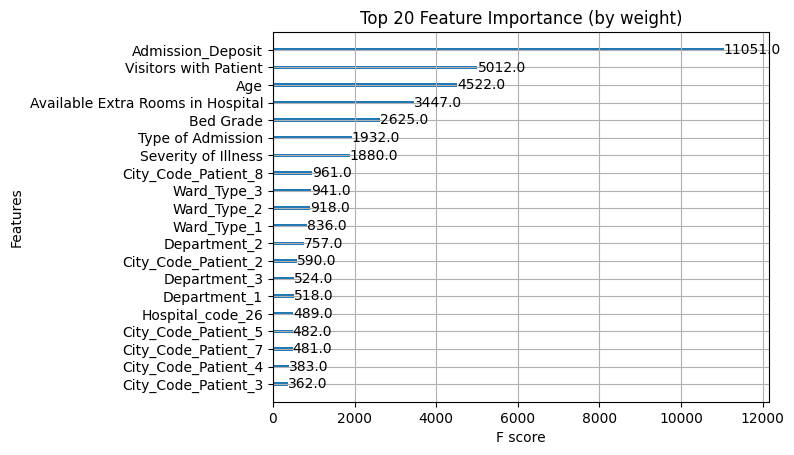

In [43]:
xgb.plot_importance(best_xgb_clf, importance_type="weight", max_num_features=20)
plt.title("Top 20 Feature Importance (by weight)")
plt.show()

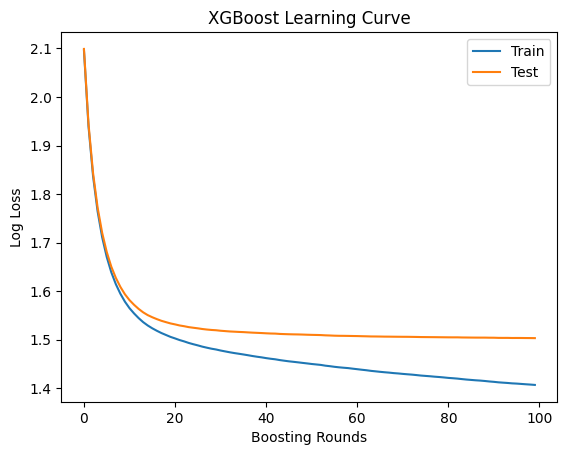

In [44]:
results = best_xgb_clf.evals_result()

epochs = len(results["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

plt.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
plt.plot(x_axis, results["validation_1"]["mlogloss"], label="Test")

plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.show()

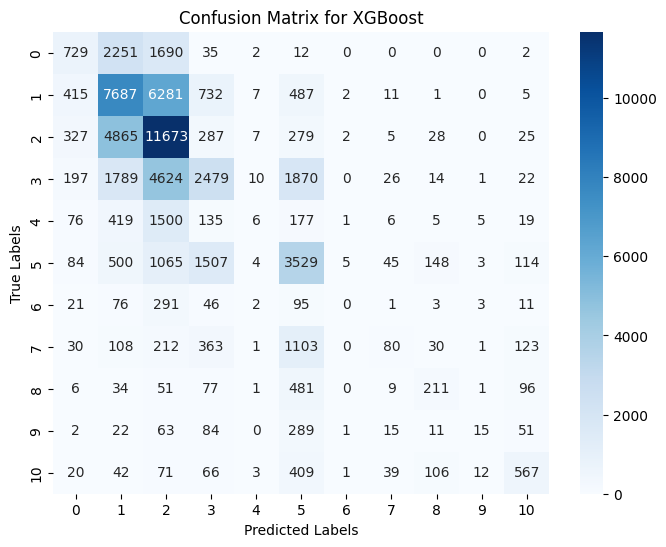

In [45]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

plt.title("Confusion Matrix for XGBoost")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the plot as an image
plt.savefig("confusion_matrix.png", dpi=300)

# Display the plot
plt.show()


In [9]:
def weighted_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds.reshape(-1, len(np.unique(labels))), axis=1)
    weights = 1 / (1 + np.abs(labels - preds))
    return "weighted_accuracy", np.mean(weights)

In [10]:
def weighted_accuracy_test(y_true, y_pred):
    weights = 1 / (1 + np.abs(y_true - y_pred))
    return np.mean(weights)
weighted_acc_test = weighted_accuracy_test(y_test, y_pred)
print(f"Weighted Accuracy (Test Set): {weighted_acc_test:.4f}")

Weighted Accuracy (Test Set): 0.6531


In [11]:
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define model parameters
params = {
    "objective": "multi:softprob",  # Softprob for multi-class classification
    "num_class": len(np.unique(y_train)),
    "eval_metric": "mlogloss"  # Default metric, can include others
}

In [12]:
weighted_xgb_clf = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dtrain, "train")],
    feval=weighted_accuracy,
    verbose_eval=True
)

C:\Users\JScot\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-mlogloss:2.09628	train-weighted_accuracy:0.63980
[1]	train-mlogloss:1.93978	train-weighted_accuracy:0.64325
[2]	train-mlogloss:1.83699	train-weighted_accuracy:0.64487
[3]	train-mlogloss:1.76435	train-weighted_accuracy:0.64688
[4]	train-mlogloss:1.71115	train-weighted_accuracy:0.64798
[5]	train-mlogloss:1.67070	train-weighted_accuracy:0.64896
[6]	train-mlogloss:1.63915	train-weighted_accuracy:0.64952
[7]	train-mlogloss:1.61459	train-weighted_accuracy:0.65006
[8]	train-mlogloss:1.59481	train-weighted_accuracy:0.65074
[9]	train-mlogloss:1.57846	train-weighted_accuracy:0.65144
[10]	train-mlogloss:1.56513	train-weighted_accuracy:0.65186
[11]	train-mlogloss:1.55430	train-weighted_accuracy:0.65220
[12]	train-mlogloss:1.54470	train-weighted_accuracy:0.65269
[13]	train-mlogloss:1.53636	train-weighted_accuracy:0.65312
[14]	train-mlogloss:1.52948	train-weighted_accuracy:0.65358
[15]	train-mlogloss:1.52365	train-weighted_accuracy:0.65394
[16]	train-mlogloss:1.51857	train-weighted_accurac

In [13]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = np.argmax(weighted_xgb_clf.predict(dtest), axis=1)

# Standard evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4225
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.17      0.23      4721
           1       0.43      0.49      0.46     15628
           2       0.43      0.66      0.52     17498
           3       0.41      0.23      0.29     11032
           4       0.12      0.01      0.01      2349
           5       0.40      0.49      0.44      7004
           6       0.00      0.00      0.00       549
           7       0.31      0.06      0.09      2051
           8       0.37      0.24      0.29       967
           9       0.33      0.04      0.07       553
          10       0.55      0.42      0.48      1336

    accuracy                           0.42     63688
   macro avg       0.34      0.25      0.26     63688
weighted avg       0.40      0.42      0.39     63688

Confusion Matrix:
 [[  805  2210  1622    58     7    15     0     0     0     2     2]
 [  494  7650  6206   765    15   476     1    12     3   

In [14]:
def weighted_accuracy_test(y_true, y_pred):
    weights = 1 / (1 + np.abs(y_true - y_pred))
    return np.mean(weights)

# Compute weighted accuracy on test data
weighted_acc_test = weighted_accuracy_test(y_test, y_pred)
print(f"Weighted Accuracy (Test Set): {weighted_acc_test:.4f}")

Weighted Accuracy (Test Set): 0.6524


In [15]:
test = pd.read_csv("test_cleaned.csv")

In [16]:
test.head()

,case_id,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Hospital_code_10,Hospital_code_11,...,City_Code_Patient_35,City_Code_Patient_36,City_Code_Patient_37,City_Code_Patient_38,City_Code_Patient_4,City_Code_Patient_5,City_Code_Patient_6,City_Code_Patient_7,City_Code_Patient_8,City_Code_Patient_9
0,318439,0.142857,0.333333,1.0,0.5,0.06250,0.777778,0.127964,False,False,...,False,False,False,False,False,False,False,False,False,False
1,318440,0.095238,0.333333,0.0,0.5,0.12500,0.777778,0.219170,False,False,...,False,False,False,False,False,False,False,False,False,False
2,318441,0.142857,1.000000,1.0,0.5,0.09375,0.777778,0.266008,False,False,...,False,False,False,False,False,False,False,False,False,False
3,318442,0.142857,0.333333,0.0,0.5,0.09375,0.777778,0.234486,False,False,...,False,False,False,False,False,False,False,False,False,False
4,318443,0.095238,0.333333,0.0,0.5,0.12500,0.777778,0.233300,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
case_ids = test["case_id"]
Pred_test = test.drop(columns=["case_id"])

In [66]:
dtest = xgb.DMatrix(Pred_test)

# Make predictions using the trained model
y_pred = smote_xgb_clf.predict(Pred_test)

In [67]:
stay_mapping = {
    0: "0-10",
    1: "11-20",
    2: "21-30",
    3: "31-40",
    4: "41-50",
    5: "51-60",
    6: "61-70",
    7: "71-80",
    8: "81-90",
    9: "91-100",
    10: "More than 100"
}

y_pred_labels = [stay_mapping[pred] for pred in y_pred]

In [68]:
predictions_df = pd.DataFrame({
    "case_id": case_ids,
    "Stay": y_pred_labels
})

predictions_df.to_csv("predictions.csv", index=False)

In [21]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [22]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({2: 69993, 1: 62511, 3: 44127, 5: 28014, 0: 18883, 4: 9394, 7: 8203, 10: 5347, 8: 3871, 9: 2212, 6: 2195})
After SMOTE: Counter({3: 69993, 2: 69993, 10: 69993, 1: 69993, 0: 69993, 5: 69993, 7: 69993, 6: 69993, 8: 69993, 4: 69993, 9: 69993})


In [39]:
smote_xgb_clf = xgb.XGBClassifier()
smote_xgb_clf.load_model("best_xgb_model.json")
smote_xgb_clf.fit(X_train_smote, y_train_smote, verbose=True)

XGBClassifier(base_score='5E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'i', 'i', 'i', 'i', 'i', 'i',
                             'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i',
                             'i'...
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
y_pred = smote_xgb_clf.predict(X_test)
print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
weighted_acc_test = weighted_accuracy_test(y_test, y_pred)
print(f"Weighted Accuracy (Test Set): {weighted_acc_test:.4f}")

Final Accuracy: 0.4146
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.26      0.29      4721
           1       0.44      0.47      0.45     15628
           2       0.43      0.65      0.52     17498
           3       0.43      0.20      0.27     11032
           4       0.12      0.01      0.01      2349
           5       0.40      0.44      0.42      7004
           6       0.05      0.00      0.01       549
           7       0.21      0.06      0.09      2051
           8       0.29      0.44      0.35       967
           9       0.12      0.07      0.09       553
          10       0.46      0.47      0.47      1336

    accuracy                           0.41     63688
   macro avg       0.30      0.28      0.27     63688
weighted avg       0.39      0.41      0.39     63688

Confusion Matrix:
 [[ 1236  1859  1565    34     5    15     0     1     0     4     2]
 [ 1028  7323  5986   643    14   564     5    19   

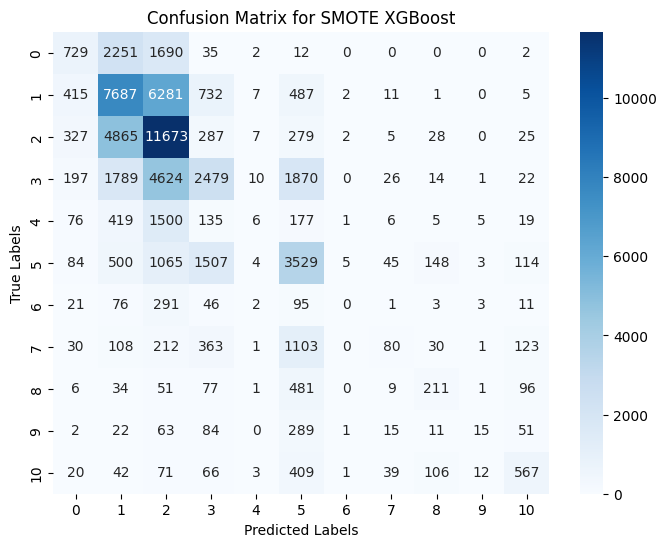

In [50]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

plt.title("Confusion Matrix for SMOTE XGBoost")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the plot as an image
plt.savefig("confusion_matrix_smote.png", dpi=300)

# Display the plot
plt.show()

 SHAP values shape: (100, 106, 11)

🔹 Class 0 SHAP Summary with SMOTE


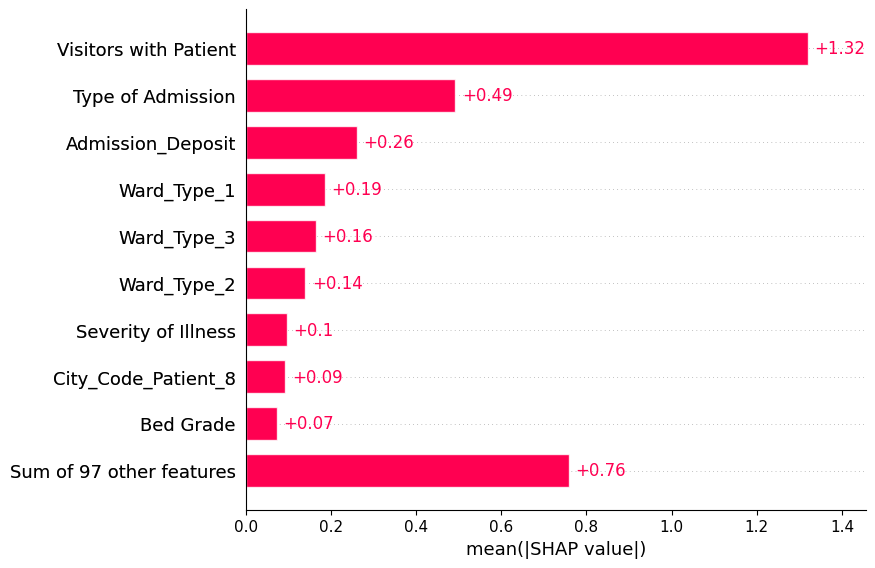


🔹 Class 1 SHAP Summary with SMOTE


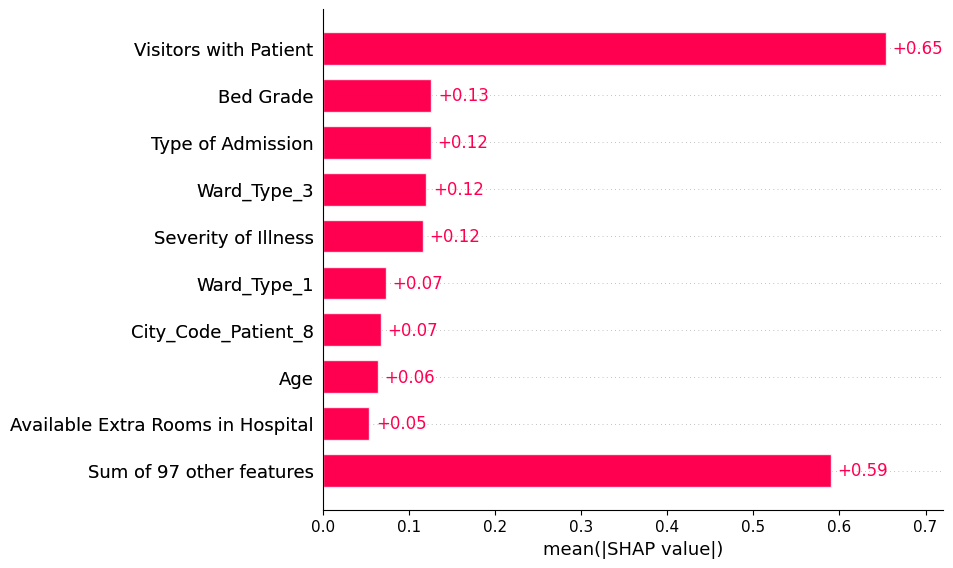


🔹 Class 2 SHAP Summary with SMOTE


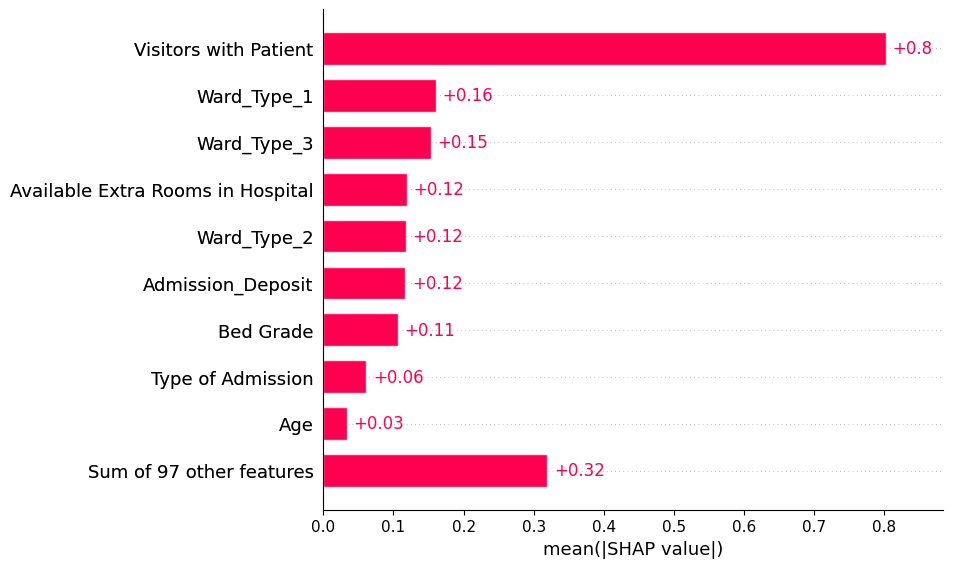


🔹 Class 3 SHAP Summary with SMOTE


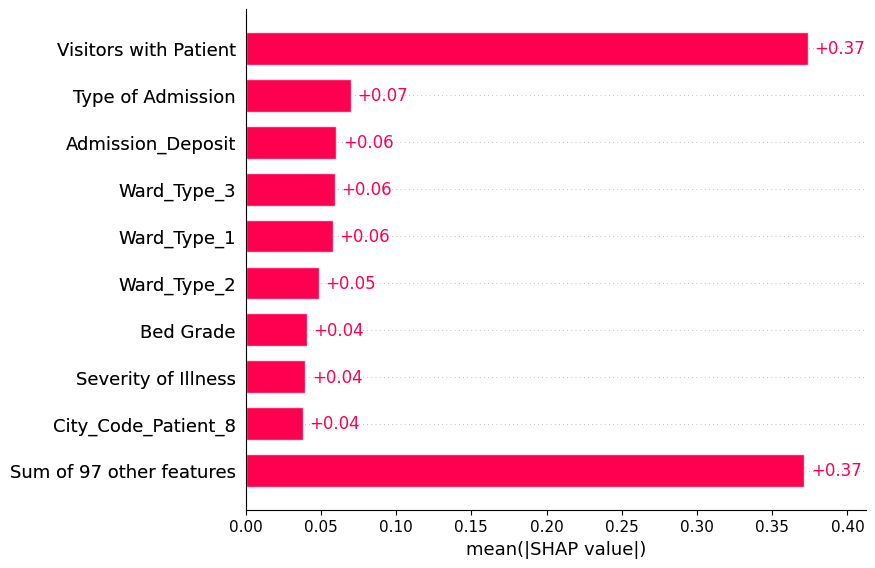


🔹 Class 4 SHAP Summary with SMOTE


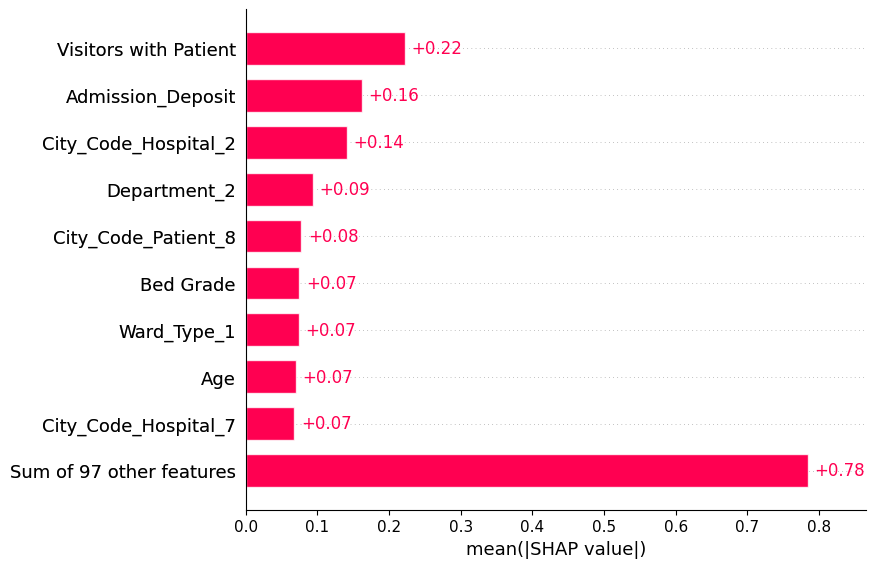


🔹 Class 5 SHAP Summary with SMOTE


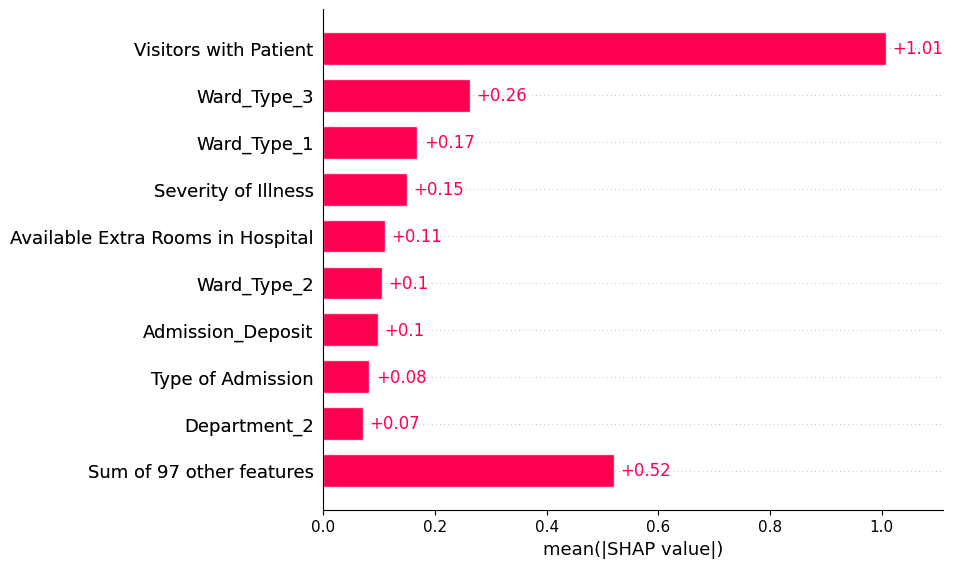


🔹 Class 6 SHAP Summary with SMOTE


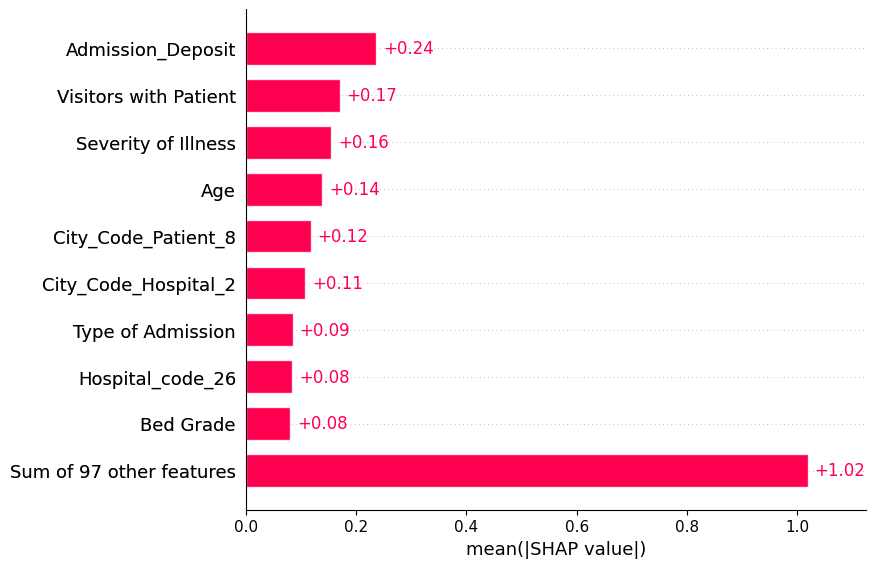


🔹 Class 7 SHAP Summary with SMOTE


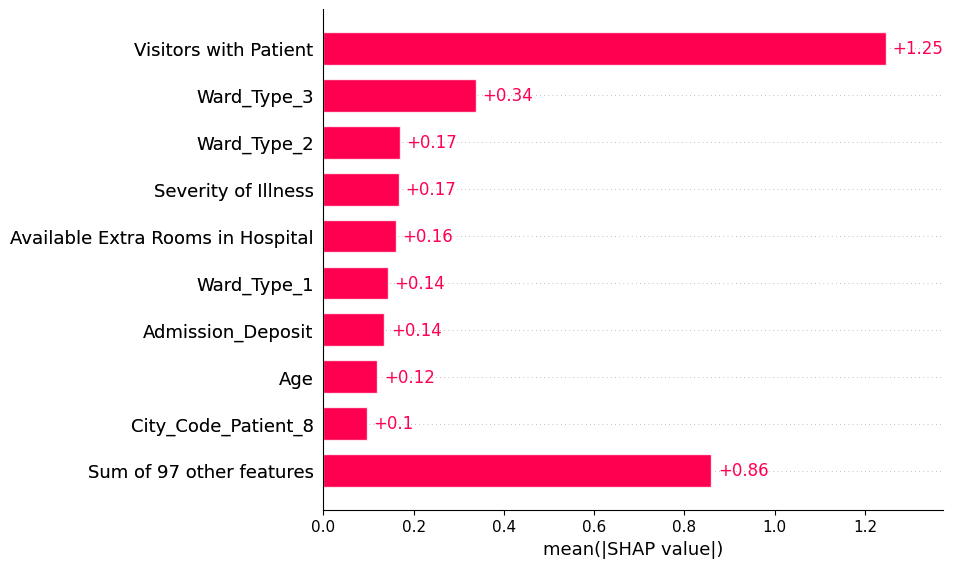


🔹 Class 8 SHAP Summary with SMOTE


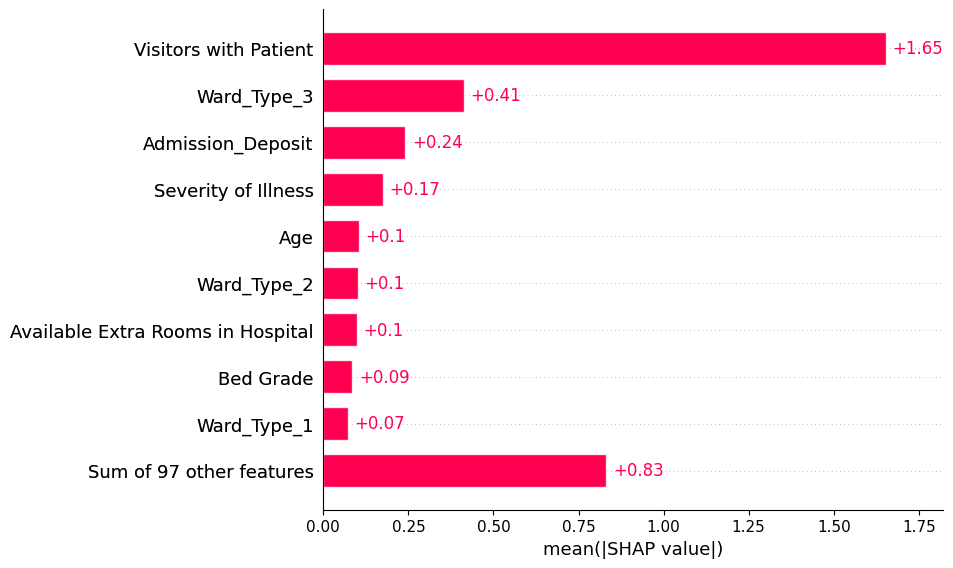


🔹 Class 9 SHAP Summary with SMOTE


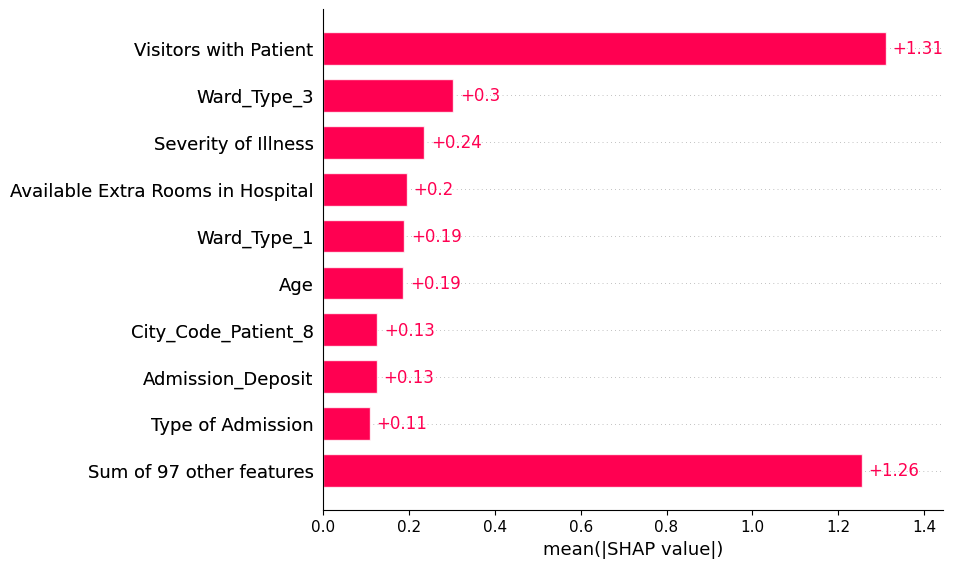


🔹 Class 10 SHAP Summary with SMOTE


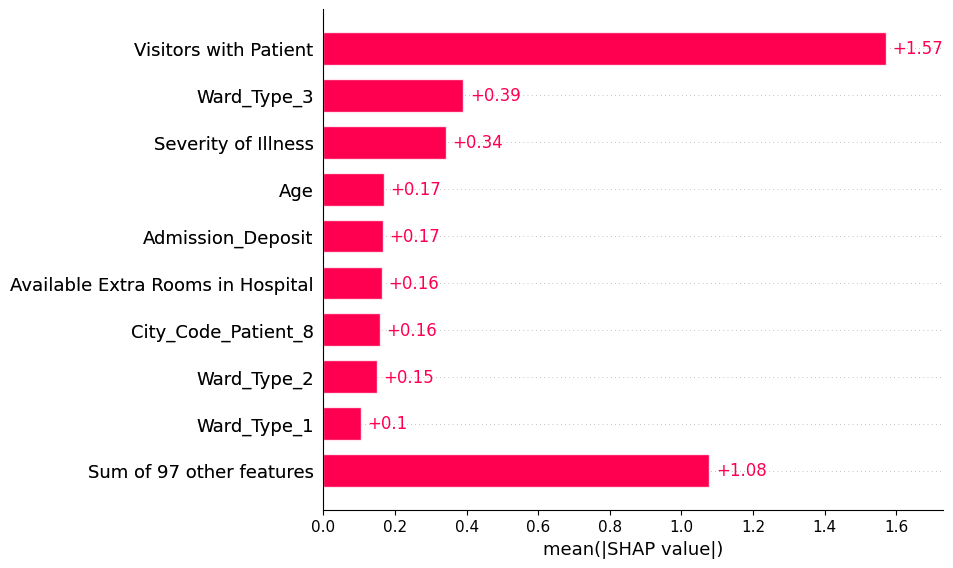

In [51]:
sample_X = X_test.sample(100, random_state=42).reset_index(drop=True)

# Create TreeExplainer
explainer = shap.Explainer(best_xgb_clf)

# Calculate SHAP values
shap_values = explainer(sample_X)
# Check output shape
print(" SHAP values shape:", shap_values.shape)  

# Plot top features for each class

for i in range(shap_values.shape[2]):  # loop over classes
    print(f"\n🔹 Class {i} SHAP Summary with SMOTE")
    shap.plots.bar(shap_values[:, :, i]) 

In [46]:
print(shap_values.shape)

(63688, 106, 11)


 SHAP values shape: (100, 106, 11)

🔹 Class 0 SHAP Summary with SMOTE


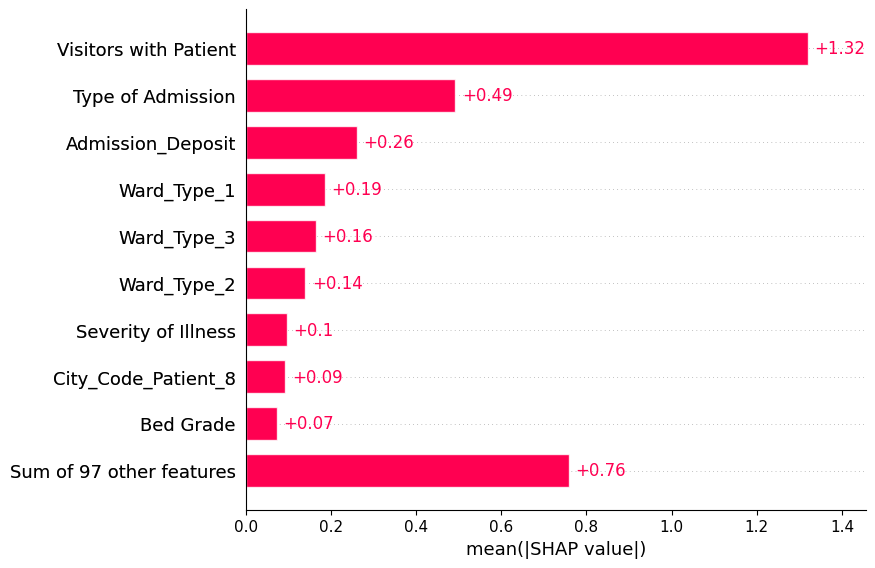


🔹 Class 1 SHAP Summary with SMOTE


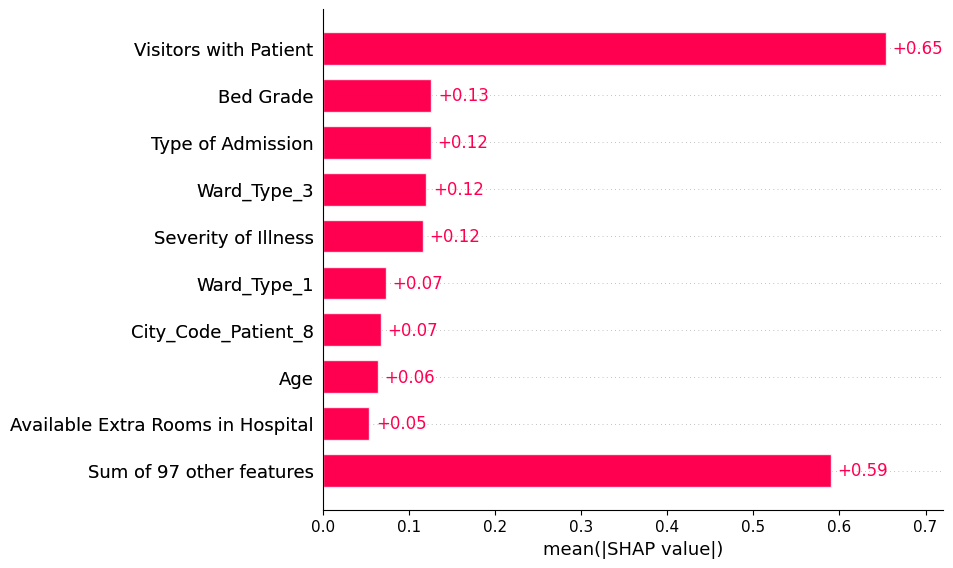


🔹 Class 2 SHAP Summary with SMOTE


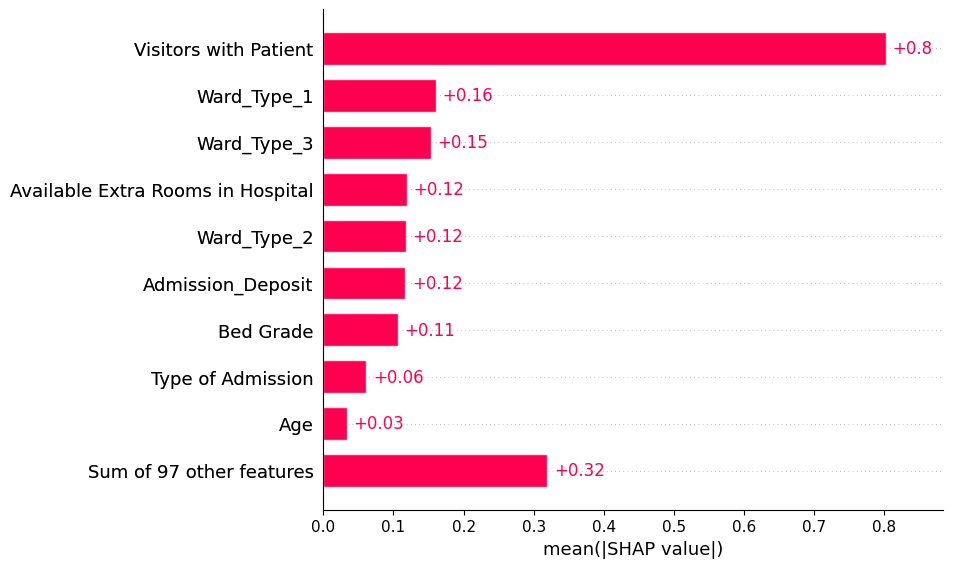


🔹 Class 3 SHAP Summary with SMOTE


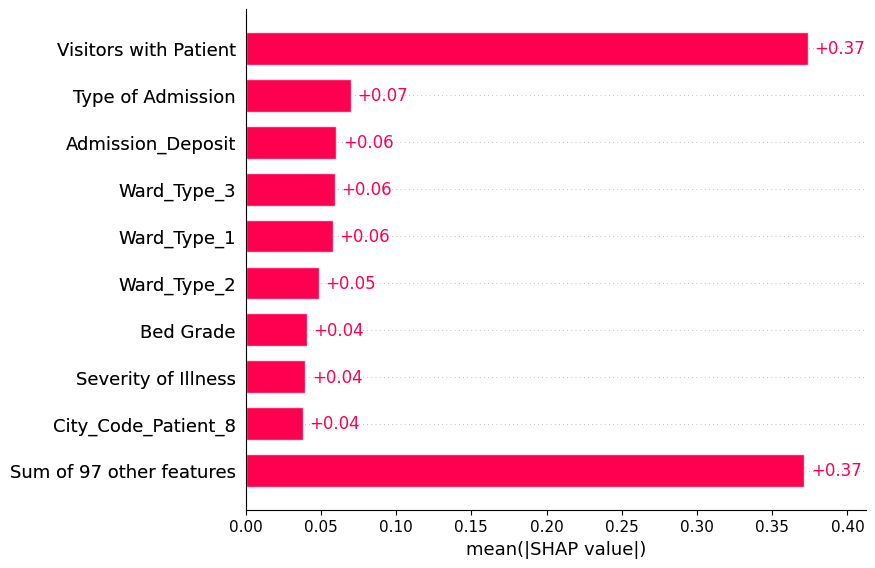


🔹 Class 4 SHAP Summary with SMOTE


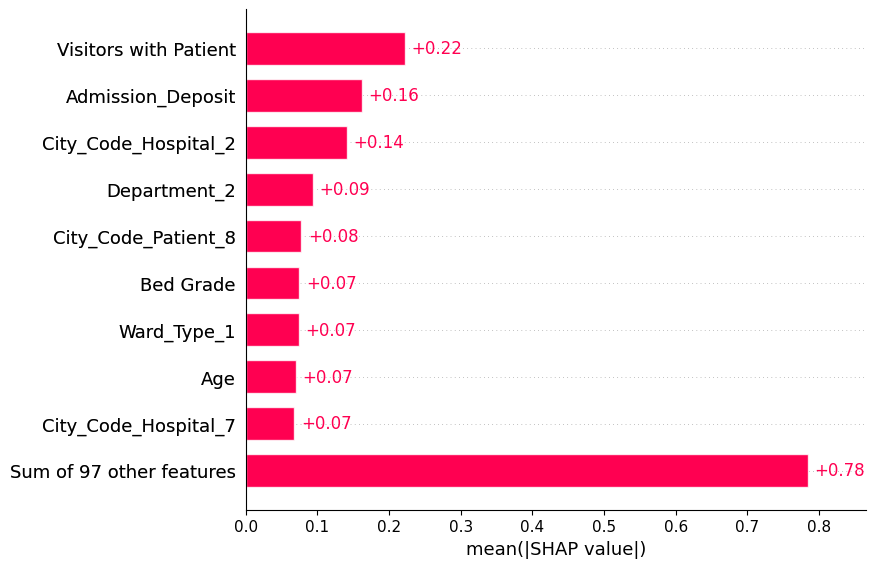


🔹 Class 5 SHAP Summary with SMOTE


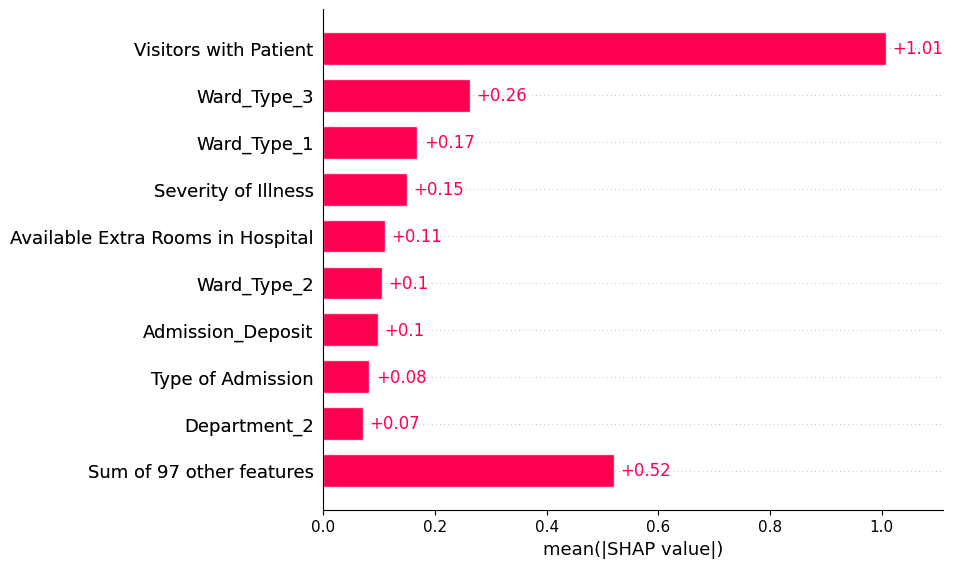


🔹 Class 6 SHAP Summary with SMOTE


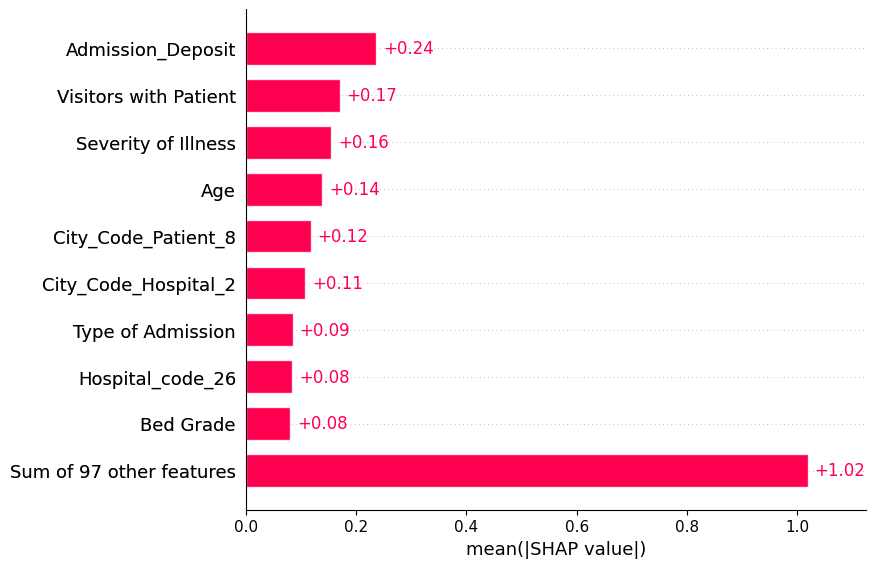


🔹 Class 7 SHAP Summary with SMOTE


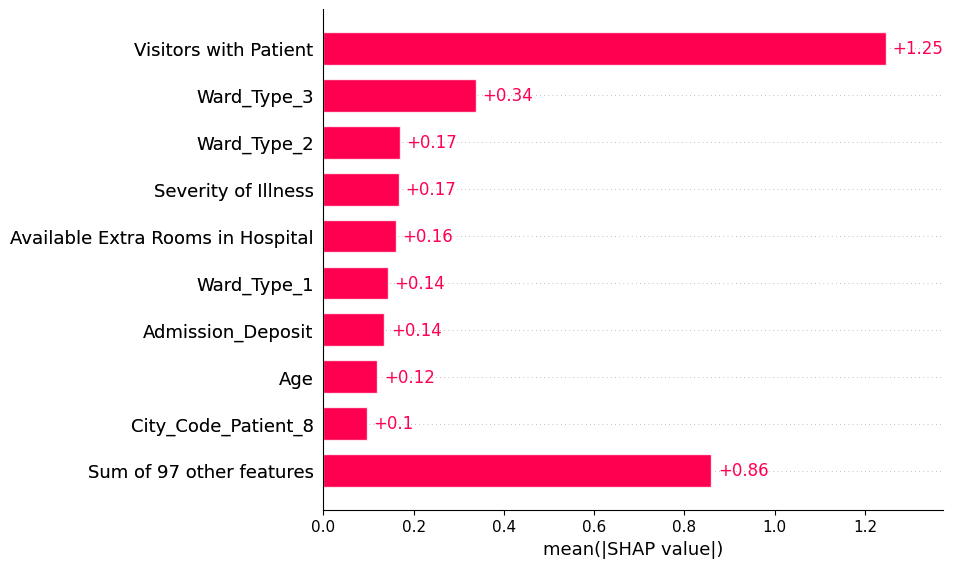


🔹 Class 8 SHAP Summary with SMOTE


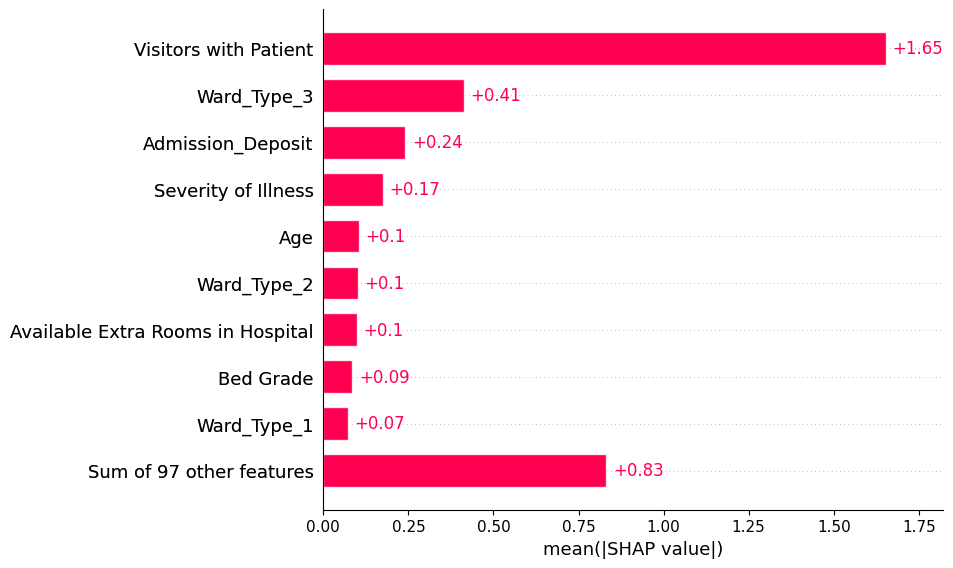


🔹 Class 9 SHAP Summary with SMOTE


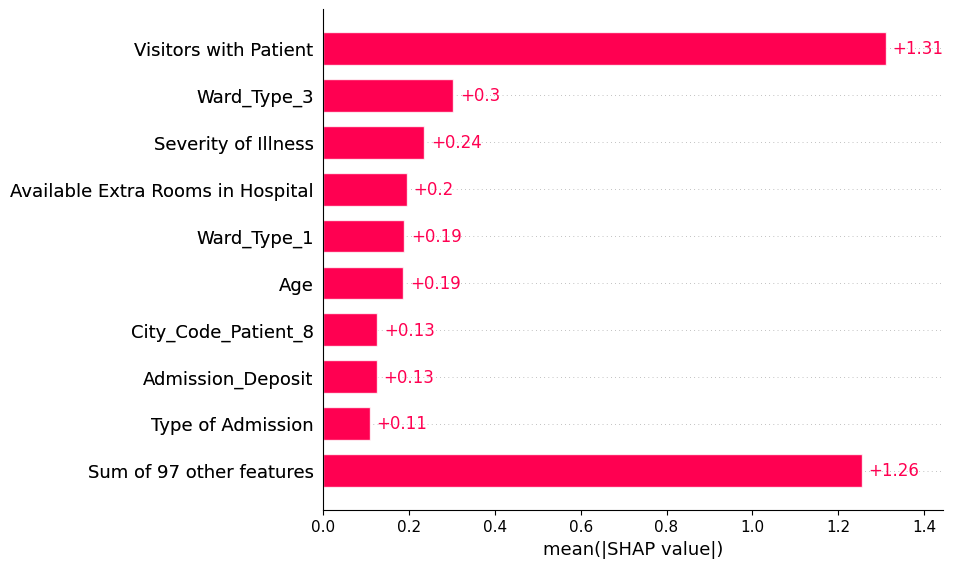


🔹 Class 10 SHAP Summary with SMOTE


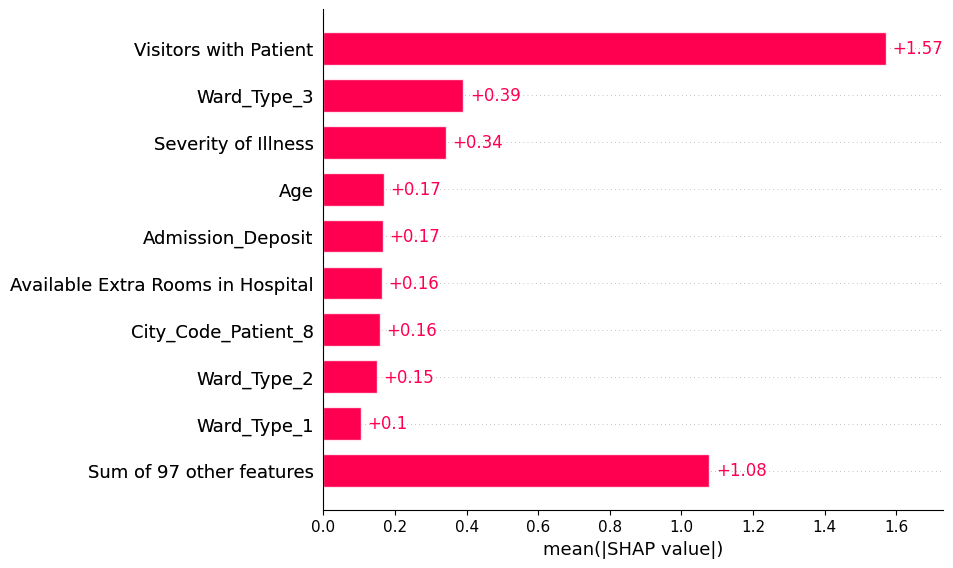

In [54]:
# Create TreeExplainer
smote_explainer = shap.Explainer(smote_xgb_clf)

# Calculate SHAP values
smote_shap_values = smote_explainer(sample_X)
# Check output shape
print(" SHAP values shape:", shap_values.shape)  

# Plot top features for each class

for i in range(shap_values.shape[2]):  # loop over classes
    print(f"\n🔹 Class {i} SHAP Summary with SMOTE")
    shap.plots.bar(shap_values[:, :, i]) 

In [57]:
def get_top_features(shap_values, feature_names, num_features=10):
    """
    Extracts top features from multi-class SHAP values by aggregating across classes.

    Parameters:
        shap_values: shap.Explanation object
        feature_names: list of feature names
        num_features: how many top features to return

    Returns:
        List of top feature names
    """
    # Aggregate over classes and samples: mean absolute SHAP value per feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))  # shape: (num_features,)

    # Get indices of top features
    top_features_idx = mean_abs_shap.argsort()[-num_features:][::-1]

    # Map indices to feature names
    top_features = [feature_names[i] for i in top_features_idx]
    return top_features


In [58]:
non_smote_shap_top_features = get_top_features(shap_values,sample_X.columns, num_features=10)
smote_shap_top_features = get_top_features(smote_shap_values,sample_X.columns, num_features=10)

In [59]:
non_smote_shap_top_features

['Visitors with Patient',
 'Ward_Type_3',
 'Admission_Deposit',
 'Severity of Illness',
 'Type of Admission',
 'Ward_Type_1',
 'Available Extra Rooms in Hospital',
 'Age',
 'Ward_Type_2',
 'City_Code_Patient_8']

In [60]:
smote_shap_top_features

['Visitors with Patient',
 'Ward_Type_3',
 'City_Code_Patient_8',
 'Severity of Illness',
 'Available Extra Rooms in Hospital',
 'Age',
 'Type of Admission',
 'Department_2',
 'Bed Grade',
 'Ward_Type_1']

In [62]:
def get_top_features_with_scores(shap_values, feature_names, num_features=10):
    """
    Returns top features with their mean absolute SHAP values, aggregated over all classes.
    """
    mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))
    top_idx = mean_abs_shap.argsort()[-num_features:][::-1]
    top_features = [feature_names[i] for i in top_idx]
    top_scores = [mean_abs_shap[i] for i in top_idx]
    return top_features, top_scores

# Get top features + scores
non_smote_top_features, non_smote_scores = get_top_features_with_scores(shap_values, sample_X.columns)
smote_top_features, smote_scores = get_top_features_with_scores(smote_shap_values, sample_X.columns)


In [63]:
# Get unique set of all features from both lists
all_features = list(set(non_smote_top_features + smote_top_features))

comparison_data = {
    "Feature": all_features,
    "Non-SMOTE Importance": [non_smote_scores[non_smote_top_features.index(f)] if f in non_smote_top_features else 0 for f in all_features],
    "SMOTE Importance": [smote_scores[smote_top_features.index(f)] if f in smote_top_features else 0 for f in all_features]
}

df_comparison = pd.DataFrame(comparison_data).sort_values(by="Non-SMOTE Importance", ascending=False)


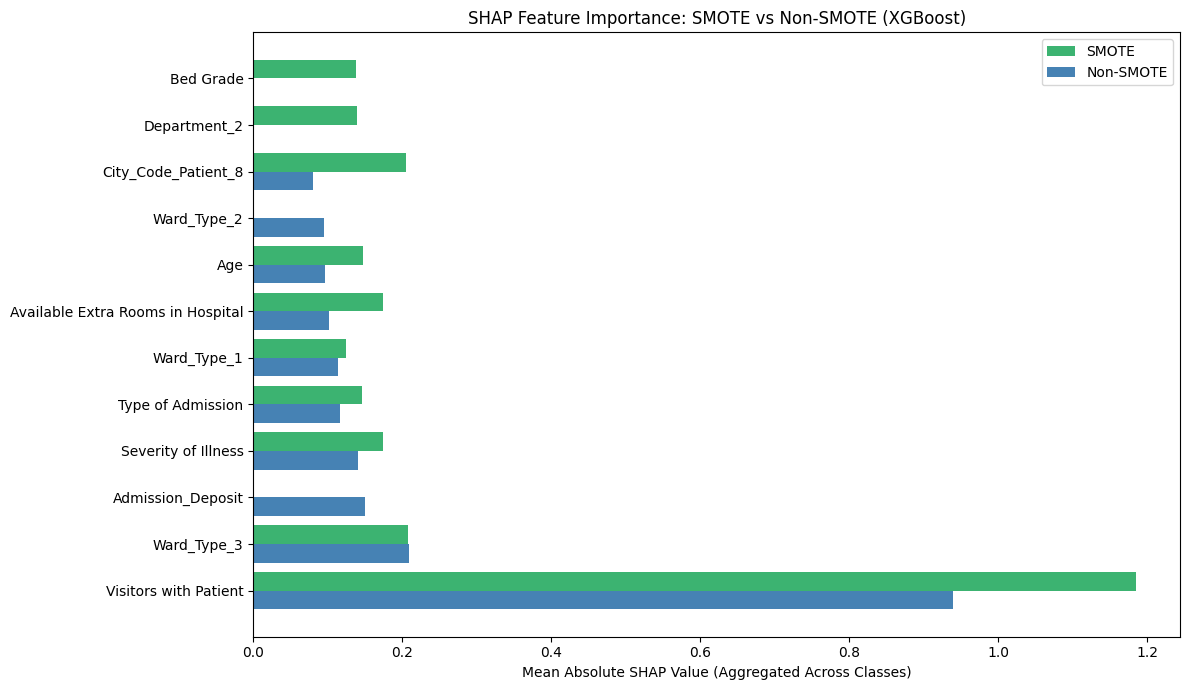

In [65]:
plt.figure(figsize=(12, 7))
bar_width = 0.4
x = range(len(df_comparison))

plt.barh(
    [i + bar_width for i in x],
    df_comparison["SMOTE Importance"],
    height=bar_width,
    label="SMOTE",
    color="mediumseagreen"
)

plt.barh(
    x,
    df_comparison["Non-SMOTE Importance"],
    height=bar_width,
    label="Non-SMOTE",
    color="steelblue"
)

plt.yticks([i + bar_width / 2 for i in x], df_comparison["Feature"])
plt.xlabel("Mean Absolute SHAP Value (Aggregated Across Classes)")
plt.title("SHAP Feature Importance: SMOTE vs Non-SMOTE (XGBoost)")
plt.legend()
plt.tight_layout()
plt.savefig("smote_shap.png", dpi=300)
plt.show()
